In [1]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
#import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/'

In [2]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


In [4]:
import csv
from ast import literal_eval

with open('simulations.csv','r') as csvfile:
    read_csv = csv.reader(csvfile, delimiter='\t')
    read_csv=list(read_csv)

df = pd.DataFrame(read_csv[1:], columns=read_csv[0])
df.lams = df.lams.apply(literal_eval) # convert back from string to list of floats
print(df)
#df.logLs = df.logLs.apply(literal_eval) # convert back from string to list of floats
df.bs = df.bs.apply(literal_eval)
df.ms = df.ms.apply(literal_eval)
df.intact_fracs = df.intact_fracs.apply(literal_eval)
logLs = df.logLs
lams = df.lams


       ms   bs                                       intact_fracs  \
0    -1.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1    -1.0  0.1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2    -1.0  0.2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3    -1.0  0.3  [0.0002003104812459312, 0.0001502328609344484,...   
4    -1.0  0.4  [5.00776203114828e-05, 0.00045069858280334516,...   
..    ...  ...                                                ...   
116   0.0  0.6  [0.6022334618658921, 0.5987781060643999, 0.596...   
117   0.0  0.7  [0.6972807852170865, 0.7000851319545295, 0.697...   
118   0.0  0.8  [0.7990385096900195, 0.8006910711602985, 0.801...   
119   0.0  0.9  [0.9013470879863789, 0.8981921979067554, 0.897...   
120   0.0  1.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                                 logLs  \
0    [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...   
1    [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in... 

In [5]:
print(df.lams[40][0:2])
print(df.logLs[40][0:30])

[[19216.0, 695.0, 54.0, 3.0, 1.0, 0.0], [19221.0, 689.0, 54.0, 2.0, 2.0, 1.0]]
[-inf, -230.75897950486114, -i


In [16]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    """
    
    logL = []
    #print(lam)
    for i in range(len(lam)):
        term3 = -lgamma(k[i]+1)
        term2 = -lam[i]
        term1 = k[i]*np.log(lam[i])
        #print(term1, term2, term3)
        logL.append(term1+term2+term3)
    return np.sum(logL)

In [7]:
print(better_loglike(df.lams[40][0], k))

[19216.0, 695.0, 54.0, 3.0, 1.0, 0.0]
193847.33689151632 -19216.0 -174642.13059215405
1596.7144903178094 -695.0 -1100.9769111472558
203.438186374778 -54.0 -152.40959258449732
13.183347464017316 -3.0 -19.987214495661885
0.0 -1.0 -10.604602902745249
-inf -0.0 -0.0
-inf


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [8]:
test_k = [19653, 244, 51, 12, 8, 1]
test_lam = [1000, 718.884, 359.442, 207.67759999999998, 63.9008, 1e-10]
better_loglike(test_lam, test_k)

[1000, 718.884, 359.442, 207.67759999999998, 63.9008, 1e-10]
135758.11449783592 -1000 -174642.13059215405
1604.958802322237 -718.884 -1100.9769111472558
300.1121942768284 -359.442 -152.40959258449732
64.03184252650297 -207.67759999999998 -19.987214495661885
33.25865504693548 -63.9008 -10.604602902745249
-23.025850929940457 -1e-10 -0.0


-40538.56317220582

#### -inf surgery: change 0s in lams to 1e-10 to avoid -infs

In [9]:
# reconstructive surgery for 0 --> 1e-12
fixed_lams = []
for x in df.lams:
    temp_fixed_lams = []
    for y in x:
        temp_fixed_lams.append([1e-12 if z==0.0 else z for z in y])
    fixed_lams.append(temp_fixed_lams)
df['fixed_lams'] = fixed_lams

In [17]:
fixed_logLs = []
for x in df.fixed_lams:
    temp_fixed_logLs = []
    for y in x:
        temp_fixed_logLs.append(better_loglike(y, k))
    fixed_logLs.append(temp_fixed_logLs)
df['fixed_logLs'] = fixed_logLs

In [18]:
df

,ms,bs,intact_fracs,logLs,lams,fixed_lams,fixed_logLs
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19256.0, 669.0, 44.0, 0.0, 0.0, 0.0], [19250...","[[19256.0, 669.0, 44.0, 1e-12, 1e-12, 1e-12], ...","[-806.7513443330784, -809.9130482406594, -785...."
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19276.0, 639.0, 54.0, 0.0, 0.0, 0.0], [19238...","[[19276.0, 639.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[-787.0997072541483, -817.0971154538378, -811...."
2,-1.0,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19229.0, 702.0, 38.0, 0.0, 0.0, 0.0], [19230...","[[19229.0, 702.0, 38.0, 1e-12, 1e-12, 1e-12], ...","[-830.0556767758704, -818.3073011005523, -827...."
3,-1.0,0.3,"[0.0002003104812459312, 0.0001502328609344484,...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19243.0, 678.0, 48.0, 0.0, 0.0, 0.0], [19232...","[[19243.0, 678.0, 48.0, 1e-12, 1e-12, 1e-12], ...","[-812.3256376092919, -489.1377593695547, -822...."
4,-1.0,0.4,"[5.00776203114828e-05, 0.00045069858280334516,...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19251.0, 668.0, 50.0, 0.0, 0.0, 0.0], [19245...","[[19251.0, 668.0, 50.0, 1e-12, 1e-12, 1e-12], ...","[-805.7005861137114, -479.1030850084702, -835...."
...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.6022334618658921, 0.5987781060643999, 0.596...","[-524.667886730223, -535.3771760342797, -559.0...","[[18768.0, 726.0, 255.0, 150.0, 55.0, 13.0], [...","[[18768.0, 726.0, 255.0, 150.0, 55.0, 13.0], [...","[-524.667886730223, -535.3771760342797, -559.0..."
117,0.0,0.7,"[0.6972807852170865, 0.7000851319545295, 0.697...","[-623.8984971417495, -603.3751887016164, -578....","[[18643.0, 796.0, 292.0, 135.0, 73.0, 27.0], [...","[[18643.0, 796.0, 292.0, 135.0, 73.0, 27.0], [...","[-623.8984971417495, -603.3751887016164, -578...."
118,0.0,0.8,"[0.7990385096900195, 0.8006910711602985, 0.801...","[-686.6116177184294, -716.7521832813926, -720....","[[18579.0, 775.0, 334.0, 178.0, 77.0, 22.0], [...","[[18579.0, 775.0, 334.0, 178.0, 77.0, 22.0], [...","[-686.6116177184294, -716.7521832813926, -720...."
119,0.0,0.9,"[0.9013470879863789, 0.8981921979067554, 0.897...","[-768.1425145723931, -790.9071078681334, -792....","[[18492.0, 770.0, 389.0, 196.0, 89.0, 27.0], [...","[[18492.0, 770.0, 389.0, 196.0, 89.0, 27.0], [...","[-768.1425145723931, -790.9071078681334, -792...."


In [32]:
logLs = df.fixed_logLs
lams = df.fixed_lams

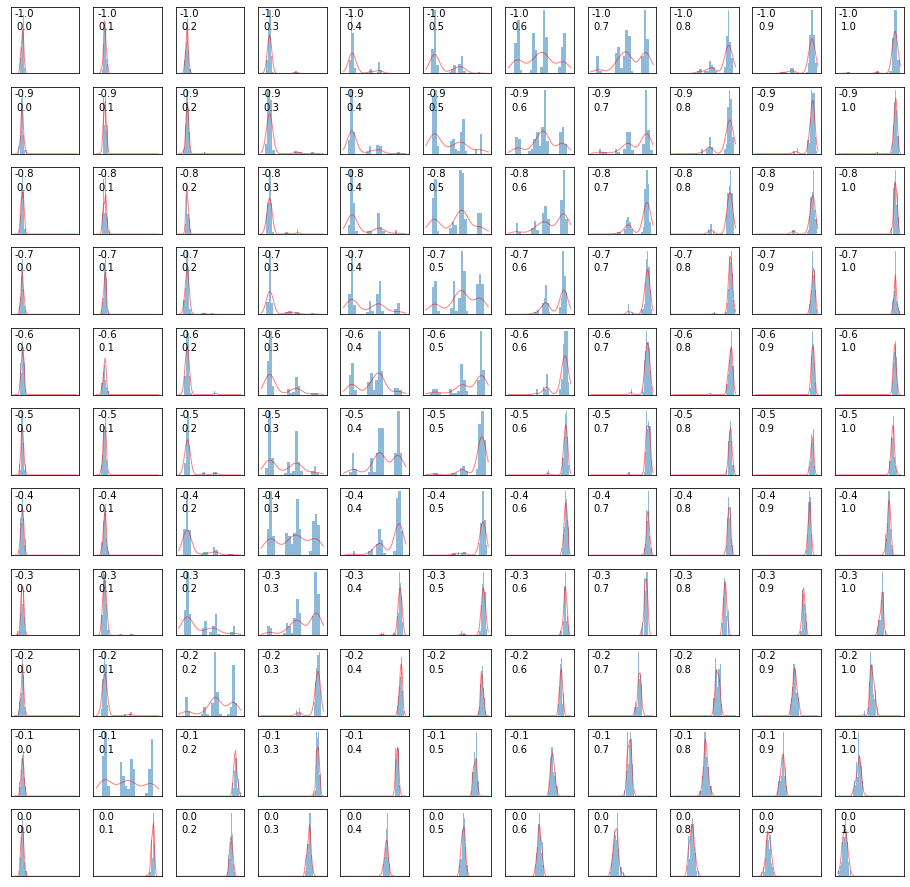

In [35]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 20
nparams = 2
draws = 50
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
logLs = df.fixed_logLs
lams = df.fixed_lams
bs = df.bs
ms = df.ms
mean_logLs = []
mean_logLs2 = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        cube = [random.uniform(0,1), random.uniform(0,1)]
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        ax.text(0.2, 0.9, round(cube[0],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, round(cube[1],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        mean_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs2.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True, alpha=0.5) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
plt.show()

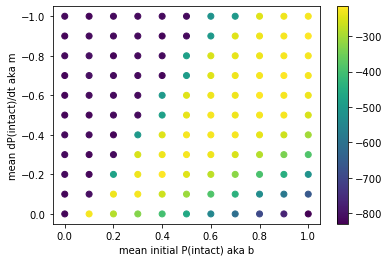

In [37]:
plt.scatter(bs, ms, c=mean_logLs)
plt.xlabel('mean initial P(intact) aka b')
plt.ylabel('mean dP(intact)/dt aka m')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

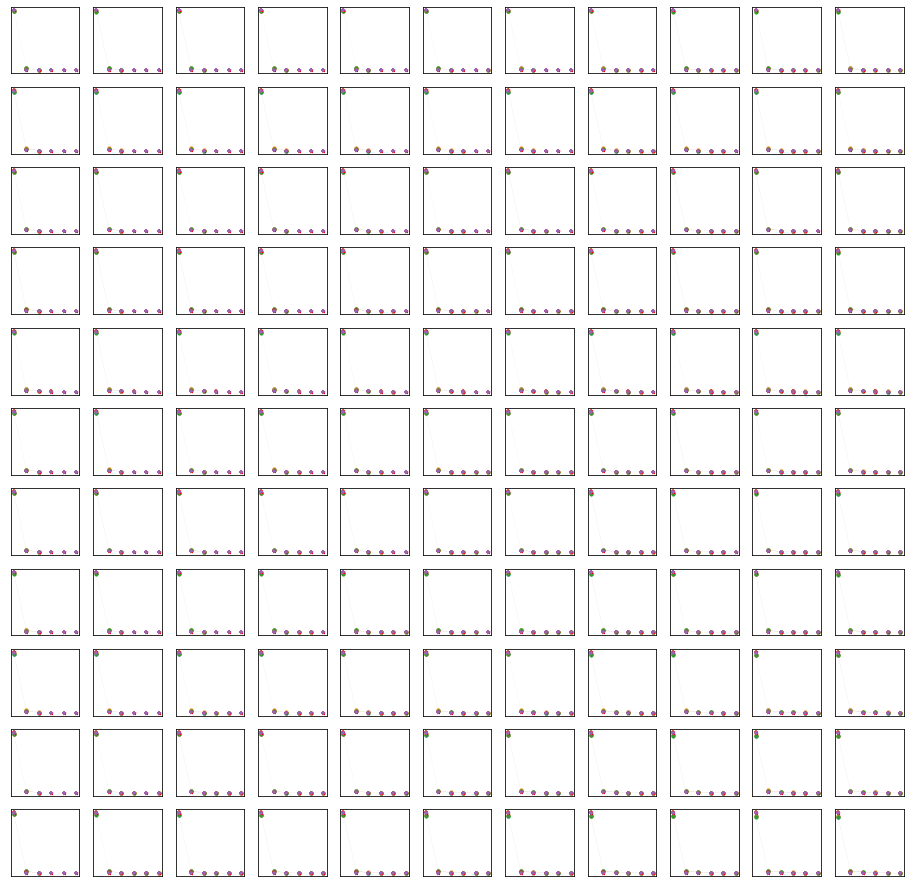

In [51]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays
plt.figure(figsize=(16,16))
index = 0

short_k = k*1000/np.sum(k)
lam_upper = []
lam_lower = []
lam_avgs = []
for gi_m in range(11):
    for gi_b in range(11):
        # avg, max, and min transit multiplicities to compare against data
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        lam_elt = lams[index]
        lam_elt_max = []
        lam_elt_min = []
        lam_elt_avg = []
        for temp_list in zip_longest(*lam_elt):
            elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
            lam_elt_max.append(max(elt))
            lam_elt_min.append(min(elt))
            lam_elt_avg.append(np.mean(elt))
        
        lam_upper.append(lam_elt_max)
        lam_lower.append(lam_elt_min)
        lam_avgs.append(lam_elt_avg)

        # plotting
        ax.scatter(pd.Series(lam_elt_avg).index, lam_elt_avg, s=10)
        ax.scatter(pd.Series(lam_elt_max).index, lam_elt_max, s=10)
        ax.scatter(pd.Series(lam_elt_min).index, lam_elt_min, s=10)
        ax.scatter(np.arange(6), k, marker=(5, 1), color='r', s=10)
        ax.scatter(np.arange(6), k+np.sqrt(k), marker='+', s=10)
        ax.scatter(np.arange(6), k-np.sqrt(k), marker='+', s=10)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #ax.set_ylim([0, 30])
        
        # draw envelope
        ax.fill_between(np.arange(len(lam_elt_min)), lam_elt_min, lam_elt_max, alpha=0.4)

        index += 1
plt.show()

In [46]:
df['mean_logLs'] = mean_logLs
df['mean_lams'] = lam_avgs

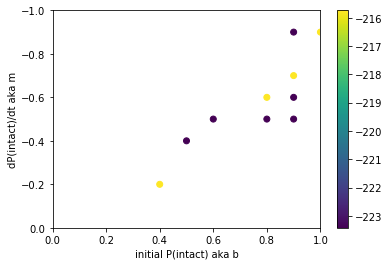

In [47]:
top_df = df.sort_values(['mean_logLs'], ascending=False).head(n=10)
plt.scatter(top_df.bs.to_list(), top_df.ms.to_list(), c=top_df.mean_logLs.to_list())
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m')
plt.xlim(0., 1.)
plt.ylim(-1., 0.)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

0    19187.12
1      689.07
2       69.35
3       14.35
4        6.81
5         NaN
dtype: float64
0    19196.20
1      687.89
2       64.89
3       12.52
4         NaN
5         NaN
dtype: float64
0    19199.93
1      683.30
2       65.67
3       11.89
4        5.96
5         NaN
dtype: float64
0    19206.84
1      684.35
2       61.64
3        9.86
4         NaN
5         NaN
dtype: float64
0    19217.52
1      685.30
2       55.34
3         NaN
4         NaN
5         NaN
dtype: float64
0    19151.11
1      688.53
2       87.28
3       26.44
4       11.89
5         NaN
dtype: float64
0    19177.15
1      687.82
2       74.42
3       18.18
4        8.66
5         NaN
dtype: float64
0    19219.85
1      680.78
2       56.93
3        7.05
4         NaN
5         NaN
dtype: float64
0    19216.96
1      684.47
2       56.56
3        6.73
4         NaN
5         NaN
dtype: float64
0    19177.86
1      690.29
2       73.53
3       16.64
4        7.65
5         NaN
dtype: float64


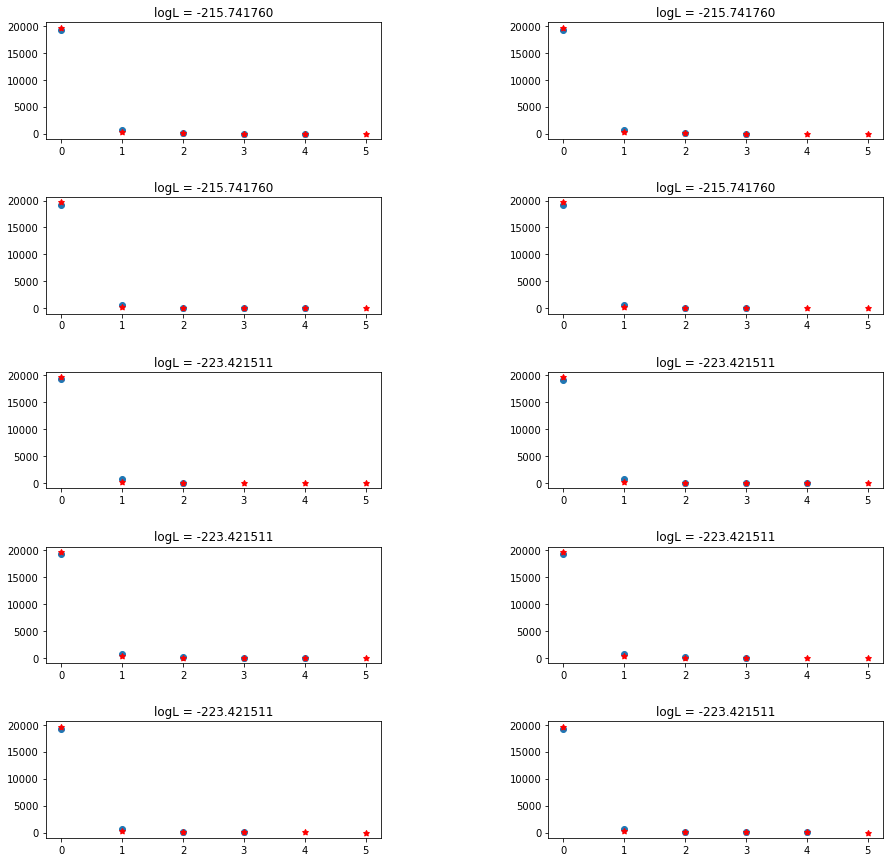

In [52]:
# Model and transit multiplicity plots for selected high-logL models
top_ms, top_bs = top_df.ms.to_list(), top_df.bs.to_list()
x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10,10))
fig.set_size_inches(15, 15)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axes = axes.flatten()

for row in range(len(top_df.ms)):    
    logL = top_df.mean_logLs.to_list()[row]
    lam = pd.Series(top_df.mean_lams.to_list()[row])
    #lam.index += 1 # reset indices starting at 1 after reading back from list
    #print(lam)
    
    plt.subplot(5,2,row+1)
    plt.title('logL = %f' %logL)
    #plt.ylabel('Count [# of systems]')
    #plt.xlabel('Multiplicity [# of transiting planets]')
    plt.scatter(pd.Series(lam).index, lam)
    plt.scatter(np.arange(6), k, marker=(5, 1), color='r')
    #plt.scatter(np.arange(6), k+np.sqrt(k), marker='+')
    #plt.scatter(np.arange(6), k-np.sqrt(k), marker='+')
    print(lam)

#plt.title('Probability of staying intact as a function of time')
plt.show()

### Redo but without zero bin

In [53]:
### re-introduce nonzero-bin transit multiplicities
df_lams_nonzero = []
for x in df.fixed_lams:
    df_lams_nonzero.append([y[1:] for y in x])
df['lams_nonzero'] = df_lams_nonzero

In [74]:
fixed_logLs_nonzero = []
for x in df.lams_nonzero:
    temp_fixed_logLs_nonzero = []
    for y in x:
        #print(y, k[1:])
        temp_fixed_logLs_nonzero.append(better_loglike(y, k[1:].reset_index()[0]))
    fixed_logLs_nonzero.append(temp_fixed_logLs_nonzero)
df['logLs_nonzero'] = fixed_logLs_nonzero

In [75]:
df

,ms,bs,intact_fracs,logLs,lams,fixed_lams,fixed_logLs,mean_logLs,mean_lams,lams_nonzero,logLs_nonzero
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19256.0, 669.0, 44.0, 0.0, 0.0, 0.0], [19250...","[[19256.0, 669.0, 44.0, 1e-12, 1e-12, 1e-12], ...","[-806.7513443330784, -809.9130482406594, -785....",-814.762398,"[19238.02, 684.71, 46.27, nan, nan, nan]","[[669.0, 44.0, 1e-12, 1e-12, 1e-12], [674.0, 4...","[-796.8247825635437, -799.8618305237736, -775...."
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19276.0, 639.0, 54.0, 0.0, 0.0, 0.0], [19238...","[[19276.0, 639.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[-787.0997072541483, -817.0971154538378, -811....",-822.442150,"[19236.53, 684.82, 47.65, nan, nan, nan]","[[639.0, 54.0, 1e-12, 1e-12, 1e-12], [685.0, 4...","[-777.5748913217664, -806.7908568077358, -801...."
2,-1.0,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19229.0, 702.0, 38.0, 0.0, 0.0, 0.0], [19230...","[[19229.0, 702.0, 38.0, 1e-12, 1e-12, 1e-12], ...","[-830.0556767758704, -818.3073011005523, -827....",-814.762398,"[19233.1, 689.45, 46.45, nan, nan, nan]","[[702.0, 38.0, 1e-12, 1e-12, 1e-12], [687.0, 5...","[-819.5531198363193, -807.8267676147567, -816...."
3,-1.0,0.3,"[0.0002003104812459312, 0.0001502328609344484,...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19243.0, 678.0, 48.0, 0.0, 0.0, 0.0], [19232...","[[19243.0, 678.0, 48.0, 1e-12, 1e-12, 1e-12], ...","[-812.3256376092919, -489.1377593695547, -822....",-814.762398,"[19235.14, 687.48, 46.35, nan, nan, nan]","[[678.0, 48.0, 1e-12, 1e-12, 1e-12], [689.0, 4...","[-802.1265747509038, -478.70111335897354, -812..."
4,-1.0,0.4,"[5.00776203114828e-05, 0.00045069858280334516,...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19251.0, 668.0, 50.0, 0.0, 0.0, 0.0], [19245...","[[19251.0, 668.0, 50.0, 1e-12, 1e-12, 1e-12], ...","[-805.7005861137114, -479.1030850084702, -835....",-814.762398,"[19238.53, 682.73, 47.55, nan, nan, nan]","[[668.0, 50.0, 1e-12, 1e-12, 1e-12], [674.0, 4...","[-795.6702769448858, -468.94652890727446, -824..."
...,...,...,...,...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.6022334618658921, 0.5987781060643999, 0.596...","[-524.667886730223, -535.3771760342797, -559.0...","[[18768.0, 726.0, 255.0, 150.0, 55.0, 13.0], [...","[[18768.0, 726.0, 255.0, 150.0, 55.0, 13.0], [...","[-524.667886730223, -535.3771760342797, -559.0...",-545.971086,"[18744.91, 737.18, 273.03, 134.14, 59.4, 17.76]","[[726.0, 255.0, 150.0, 55.0, 13.0], [718.0, 26...","[-498.260438341354, -508.4953896050148, -530.6..."
117,0.0,0.7,"[0.6972807852170865, 0.7000851319545295, 0.697...","[-623.8984971417495, -603.3751887016164, -578....","[[18643.0, 796.0, 292.0, 135.0, 73.0, 27.0], [...","[[18643.0, 796.0, 292.0, 135.0, 73.0, 27.0], [...","[-623.8984971417495, -603.3751887016164, -578....",-607.409100,"[18660.38, 747.16, 310.32, 157.86, 69.36, 20.73]","[[796.0, 292.0, 135.0, 73.0, 27.0], [739.0, 31...","[-591.1588661319958, -572.4971209754634, -548...."
118,0.0,0.8,"[0.7990385096900195, 0.8006910711602985, 0.801...","[-686.6116177184294, -716.7521832813926, -720....","[[18579.0, 775.0, 334.0, 178.0, 77.0, 22.0], [...","[[18579.0, 775.0, 334.0, 178.0, 77.0, 22.0], [...","[-686.6116177184294, -716.7521832813926, -720....",-691.886369,"[18576.09, 760.55, 346.03, 181.0, 79.52, 22.35]","[[775.0, 334.0, 178.0, 77.0, 22.0], [758.0, 37...","[-650.2886628944389, -678.6098171619068, -682...."
119,0.0,0.9,"[0.9013470879863789, 0.8981921979067554, 0.897...","[-768.1425145723931, -790.9071078681334, -792....","[[18492.0, 770.0, 389.0, 196.0, 89.0, 27.0], [...","[[18492.0, 770.0, 389.0, 196.0, 89.0, 27.0], [...","[-768.1425145723931, -790.9071078681334, -792....",-768.683887,"[18499.53, 764.21, 382.68, 202.15, 90.09, 26.57]","[[770.0, 389.0, 196.0, 89.0, 27.0], [791.0, 40..."

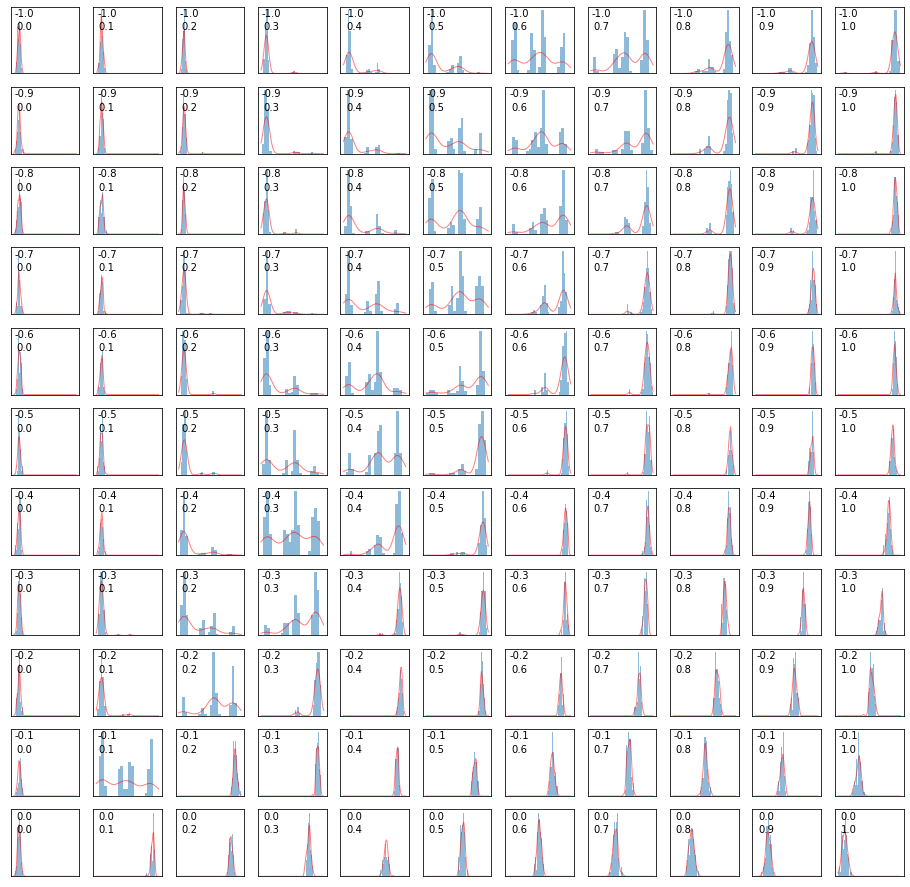

In [85]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 20
nparams = 2
draws = 50
logLs = df.logLs_nonzero
lams = df.lams_nonzero
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df.bs
ms = df.ms
mean_logLs = []
mean_logLs2 = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        cube = [random.uniform(0,1), random.uniform(0,1)]
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        ax.text(0.2, 0.9, round(cube[0],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, round(cube[1],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        mean_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs2.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True, alpha=0.5) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
plt.show()

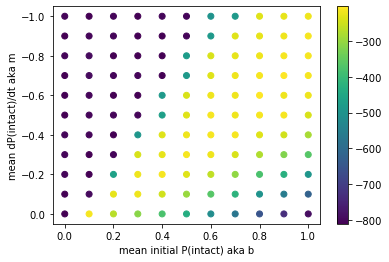

In [77]:
plt.scatter(bs, ms, c=mean_logLs)
plt.xlabel('mean initial P(intact) aka b')
plt.ylabel('mean dP(intact)/dt aka m')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [80]:
df.loc[:, "mean_intact_fracs"] = df.intact_fracs.apply(lambda x: np.mean(x))

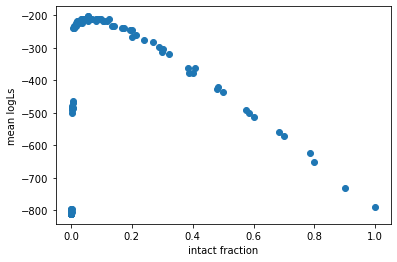

In [82]:
plt.scatter(df.mean_intact_fracs, mean_logLs)
plt.ylabel('mean logLs')
plt.xlabel('intact fraction')
plt.show()